This step involves applying various data mining techniques to the transformed data to discover hidden patterns, trends, relationships, and insights. 

In [1]:
import utils
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline

# Load data
df: pd.DataFrame = utils.load_preprocessed_data()

# split data into train and test
X_train, _, y_train, _ = utils.split_data(df)

### Model Building

In this phase, we are developing a pipeline of machine learning algorithms, which includes tree-based algorithms such as:
- Decision tree learning employs a divide and conquer strategy by conducting a greedy search to identify the optimal split points within a tree. It’s  insensitive to underlying relationships between attributes; this means that if two variables are highly correlated, the algorithm will only choose one of the features to split on. They are prone to overfitting: Complex decision trees tend to overfit and do not generalize well to new data, which can lead to small variations within the data producing a very different decision tree. This scenario can be avoided through the processes of pre-pruning or post-pruning.
- RF is a bagging technique that trains multiple decision trees in parallel and determines the final output via a majority vote, resulting in a possible method of reducing variance of decision trees. However, this approach is limited as it can lead to highly correlated predictors.  
- XGBoost is a boosting technique that sequentially creates decision trees, each tree improving upon the mistakes of the previous one. The final result is a sum of outputs from all the trees. Random forests combine results at the end of the process (by averaging or “majority rules”) while gradient boosting combines results along the way.
- Bagging and boosting are two ensemble techniques that can strengthen models. Random Forest generates many trees, each with leaves of equal weight within the model, in order to obtain better results. On the other hand, Gradient Descent Boosting introduces leaf weighting to penalize those that do not improve the model predictability. Both decision tree algorithms generally decrease the variance, while boosting also improves the bias. 

Cost-sensitive learning:
- Cost-sensitive learning is a subfield of machine learning that involves explicitly defining and using costs when training machine learning algorithms.
- It is a field of study that is closely related to the field of imbalanced learning that is concerned with classification on datasets with a skewed class distribution. As such, many conceptualizations and techniques developed and used for cost-sensitive learning can be adopted for imbalanced classification problems.
- The scikit-learn library provides this capability for a range of algorithms via the class_weight attribute specified when defining the model. A weighting can be specified that is inversely proportional to the class distribution. The scikit-learn library provides this capability for a range of algorithms via the class_weight attribute specified when defining the model. A weighting can be specified that is inversely proportional to the class distribution, in an automatic way, by setting the class_weight argument to the string ‘balanced‘.

In [3]:
# Model selection process with pipeline of models
pipeline_lr=Pipeline([('lr_classifier',LogisticRegression(random_state=0, class_weight='balanced'))])

pipeline_svc=Pipeline([('svc_classifier',SVC(random_state=0, class_weight='balanced'))])

pipeline_knn=Pipeline([('knn_classifier',KNeighborsClassifier())])

pipeline_dt=Pipeline([ ('dt_classifier',DecisionTreeClassifier(random_state=0, class_weight='balanced'))])

pipeline_rf=Pipeline([('rf_classifier',RandomForestClassifier(random_state=0, class_weight='balanced'))])

pipeline_xgb=Pipeline([('xgb_classifier',XGBClassifier(random_state=0, class_weight='balanced'))])

pipeline_mpl=Pipeline([('mpl_classifier',MLPClassifier(random_state=0))])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_svc, pipeline_knn, pipeline_dt, pipeline_rf, pipeline_xgb, pipeline_mpl]

# Dictionary of pipelines and classifier types
pipe_dict = {0: 'LR',
            1: 'SVC',
            2: 'KNN', 
            3: "DT",
            4: "RF",
            5: "XGB",
            6: "MLP"
            }


# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

#cross validation on accuracy
print("Accuracy results with 10-fold cross-validation:")
cv_results_accuracy = []


for i, model in enumerate(pipelines):
    """
    The cross_val_score() function will be used to perform the evaluation,
    taking the training dataset and cross-validation configuration and returning
    a list of scores calculated for each fold.
    """ 
    # StratifiedKFold is more suitable for imbalanced data to ensure that each fold represents the class distribution of the entire data.
    # This ensures that the model is evaluated in a way that reflects its ability to generalize to all classes, including minority classes.
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cv_score = cross_val_score(model, X_train, y_train, cv=skf, scoring="accuracy")
    cv_results_accuracy.append(cv_score)
    print("%s: %.3f (%.3f) " % (pipe_dict[i], cv_score.mean(), cv_score.std()))

Accuracy results with 10-fold cross-validation:
LR: 0.866 (0.024) 
SVC: 0.884 (0.025) 
KNN: 0.904 (0.009) 
DT: 0.919 (0.020) 
RF: 0.939 (0.014) 
XGB: 0.954 (0.011) 
MLP: 0.930 (0.013) 


The amount of difference in the estimated performance from one run of k-fold cross-validation to another is dependent upon the model that is being used and on the dataset itself. One possible solution is to reduce the noise in the estimated model performance is to increase the k-value. This will reduce the bias in the model’s estimated performance, although it will increase the variance.

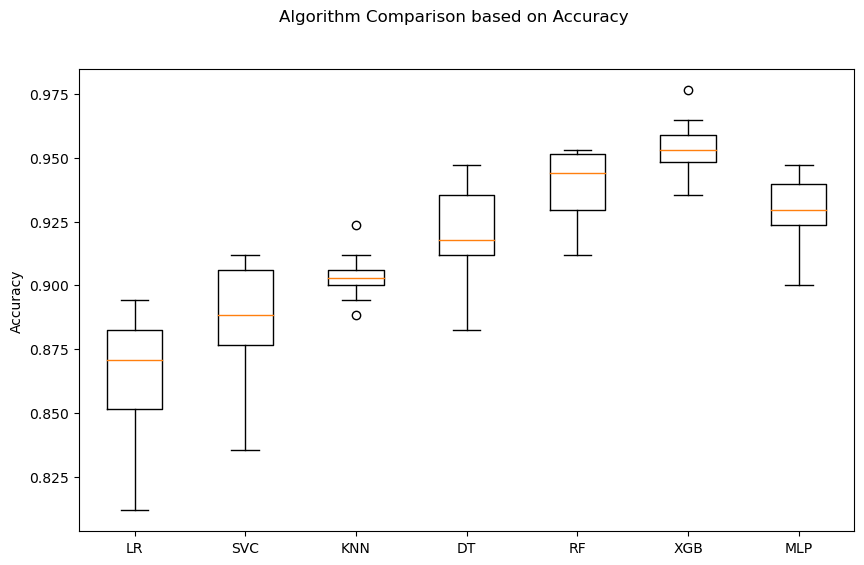

In [9]:
# boxplot algorithm comparison
utils.algorithm_comparison(cv_results_accuracy, pipe_dict, "Algorithm Comparison based on Accuracy")

- Because Accuracy is sensitive to the class distribution, F1 score is also evaluated. It considers both precision and recall, providing a balance between false positives and false negatives. This is particularly important when the class distribution is uneven, as accuracy may be misleading if the majority class dominates.                  
- F1 score should provide a more nuanced understanding of the tested model's performance, especially in capturing the minority classes.

F1 results with 10-fold cross-validation:
LR: 0.876 (0.020) 
SVC: 0.893 (0.021) 
KNN: 0.898 (0.010) 
DT: 0.918 (0.020) 
RF: 0.936 (0.015) 
XGB: 0.953 (0.011) 
MLP: 0.929 (0.014) 


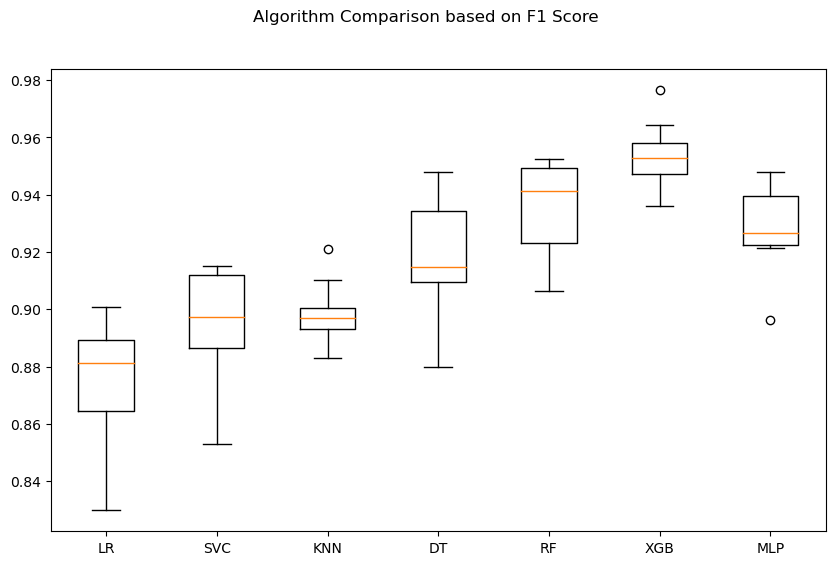

In [6]:
print("F1 results with 10-fold cross-validation:")
cv_results_f1 = []


for i, model in enumerate(pipelines):
    """
    The cross_val_score() function will be used to perform the evaluation,
    taking the training dataset and cross-validation configuration and returning
    a list of scores calculated for each fold.
    """
    # The weighted average F1 score is used to:
    # compute the average F1 score by considering the number of samples in each class.
    # Ensures that the performance metric reflects the contribution of each class proportionally to its representation in the dataset.
    scorer = make_scorer(f1_score, average='weighted')  
    # StratifiedKFold is more suitable for imbalanced data to ensure that each fold represents the class distribution of the entire data.
    # This ensures that the model is evaluated in a way that reflects its ability to generalize to all classes, including minority classes.
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cv_score = cross_val_score(model, X_train, y_train, cv=skf, scoring=scorer)
    cv_results_f1.append(cv_score)
    print("%s: %.3f (%.3f) " % (pipe_dict[i], cv_score.mean(), cv_score.std()))

utils.algorithm_comparison(cv_results_f1, pipe_dict, "Algorithm Comparison based on F1 Score")

- As a result of this analysis, XGBoost is the best performer compared with the other model's performance: Highest mean and low variance (spread of error that may be expected from the sample mean to the underlying and unknown population mean.)

#### Bias-variance trade-off

- Bias-variance trade-off is a fundamental concept in machine learning that refers to the trade-off between the ability of a model to fit the training data (low bias) and its ability to generalise to new, unseen data (low variance). If the algorithm is too simple then it may be underfitting and on high bias and low variance condition, and thus is error-prone. If algorithms fit is too complex, then it may be overfitting and on high variance and low bias. In the latter condition, the new entries will not perform well.
- A model with high bias makes strong assumptions about the form of the unknown underlying function that maps inputs to outputs in the dataset, such as linear regression. A model with high variance is highly dependent upon the specifics of the training dataset, such as unpruned decision trees. We desire models with low bias and low variance, although there is often a trade-off between these two concerns.

Error(Model) : defined as prediction error on all examples not used to train the model.                                     
Error(Model) = Variance(Model) + Bias(Model) + Variance(Irreducible Error)

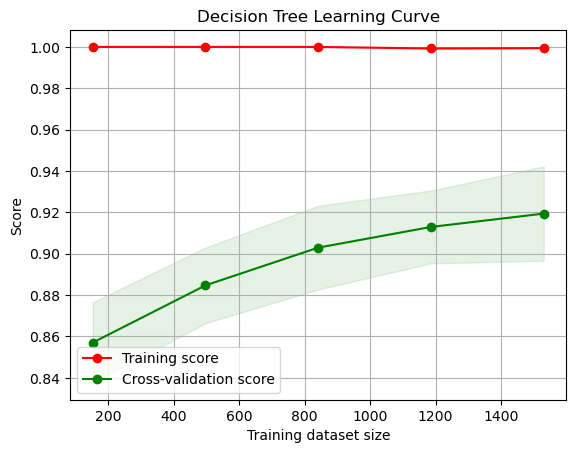

In [3]:
# Decision Tree Learning Curve
dt_lrcurve = utils.plot_learning_curve(pipelines[3], "Decision Tree Learning Curve", X_train, y_train, cv=10)
dt_lrcurve.show()

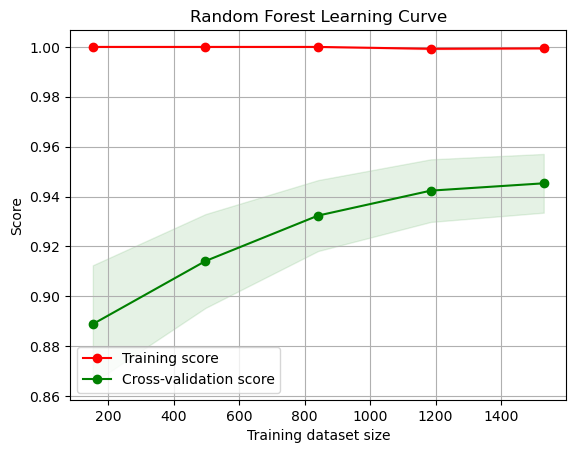

In [4]:
# Random Forest Learning Curve
rf_lrcurve = utils.plot_learning_curve(pipelines[4], "Random Forest Learning Curve", X_train, y_train, cv=10)
rf_lrcurve.show()

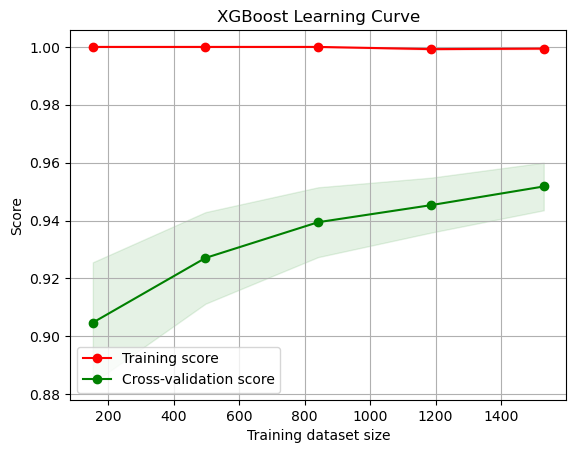

In [5]:
# XGBoost Learning Curve
xgboost_lrcurve = utils.plot_learning_curve(pipelines[5], "XGBoost Learning Curve", X_train, y_train, cv=10)
xgboost_lrcurve.show()

In [8]:
# accuracy for each model on the training data
print("Accuracy results on the training data:")
train_accuracy = []

for i, model in enumerate(pipelines):
    train_accuracy.append(model.score(X_train, y_train))
    print("%s: %.3f" % (pipe_dict[i], train_accuracy[i]))

Accuracy results on the training data:
LR: 0.908
SVC: 0.933
KNN: 0.935
DT: 0.999
RF: 0.999
XGB: 0.999
MLP: 0.974


- The similar accuracy scores for of all three models (Decision Tree, Random Forest, and XGBoost) on the training dataset indicate that they have similar bias, although  it doesn't provide a definitive conclusion about bias because accuracy alone doesn't directly measure bias.

- XGBoost's decrease in the standard deviation of cross-validation results as the training dataset size increases is a sign of better generalization. It suggests that as more data is provided, XGBoost becomes more stable and consistent in its performance across different subsets of the data. This is desirable because it means that XGBoost is less likely to overfit the training data.

- The fact that XGBoost exhibits a larger decrease in standard deviation implies that it has lower variance compared to the other models. Lower variance means that the model's performance is less sensitive to variations in the training data, which is crucial for making accurate predictions on unseen data.

- Lower variance also suggests that XGBoost is less prone to overfitting. Overfitting occurs when a model learns the noise in the training data, which can lead to poor generalization. The lower variance of XGBoost indicates that it's better at capturing the underlying patterns in the data while ignoring noise.

### Hyperparameter Optimization with nested cross-validation - XGBoost 

In [3]:
# Hyperparameter tuning with nested cross-validation

# Define the pipeline
pipeline_xgb = Pipeline([('xgb_classifier', XGBClassifier(random_state=0))])

# Define hyperparameter grid
parameters = {
    'xgb_classifier__max_depth': [3, 5, 7],
    'xgb_classifier__min_child_weight': [1, 3, 5],
    'xgb_classifier__subsample': [0.5, 0.7],
    'xgb_classifier__colsample_bytree': [0.5, 0.7],
    'xgb_classifier__n_estimators': [100, 200, 500],
    'xgb_classifier__learning_rate': [0.01, 0.05, 0.1]
}

# Define outer and inner cross-validation
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Perform nested cross-validation with StratifiedKFold
scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(pipeline_xgb, parameters, cv=inner_cv, scoring=scorer, n_jobs=-1)
nested_score = cross_val_score(grid_search, X_train, y_train, cv=outer_cv)

# Print the results
print("Nested StratifiedKFold Cross-Validation f1: %0.3f (+/- %0.3f)" % (nested_score.mean(), nested_score.std() * 2))

Nested StratifiedKFold Cross-Validation f1: 0.957 (+/- 0.007)


In [4]:
# Fit the best model on the entire training set
grid_search.fit(X_train, y_train)

# Retrieve the best parameters from the hypertuned model
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

# save model
pd.to_pickle(grid_search, '../artifacts/xgb_classifier.pkl')

Best parameters:  {'xgb_classifier__colsample_bytree': 0.5, 'xgb_classifier__learning_rate': 0.1, 'xgb_classifier__max_depth': 3, 'xgb_classifier__min_child_weight': 1, 'xgb_classifier__n_estimators': 200, 'xgb_classifier__subsample': 0.7}
